In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from influxdb import *
import datetime
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
import statistics

In [2]:
df = pd.read_excel(r'C:\Users\u23e02\Downloads\Data_7_14.xlsx')
df = df.rename(columns = {'Unnamed: 0':'time'}).set_index('time')
df.index.freq = 'H'

In [3]:
df[df['EM4'] < 0] = 0

In [4]:
df.head()

,EM4
time,
2020-06-14 11:00:00,26.0
2020-06-14 12:00:00,111.0
2020-06-14 13:00:00,120.0
2020-06-14 14:00:00,27.0
2020-06-14 15:00:00,109.0


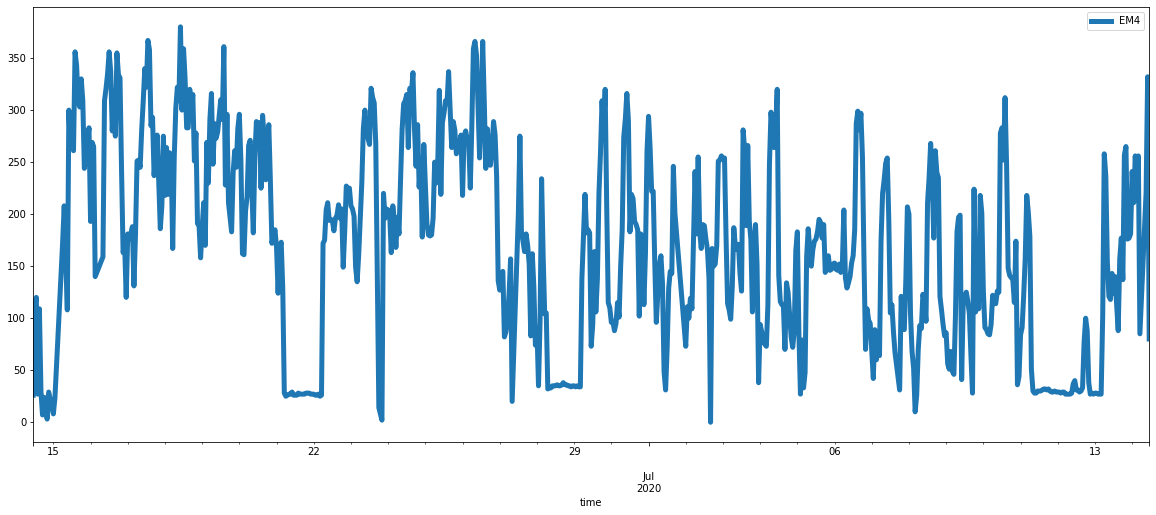

In [5]:
df.plot(figsize = (20,8), lw = 5)

In [6]:
result = seasonal_decompose(df['EM4'], model='additive')
# result.plot()
# plt.show()

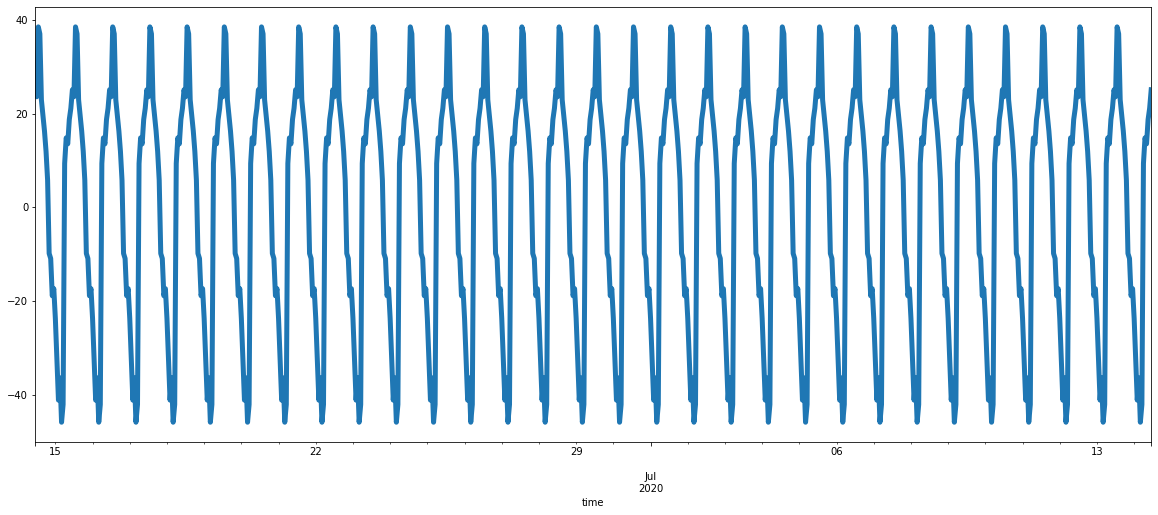

In [7]:
result.seasonal.plot(figsize = (20,8), lw = 5)

In [8]:
EM4 = df.copy()

In [9]:
from statsmodels.tsa.stattools import adfuller
result_l = adfuller(EM4['EM4'])
print('ADF Statistic: %f' % result_l[0])
print('p-value: %.12f' % result_l[1])
print('Critical Values:')
for key, value in result_l[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.695342
p-value: 0.004179153621
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=7206.539, BIC=7229.061, Fit time=49.638 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=7576.625, BIC=7585.634, Fit time=0.923 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=7380.290, BIC=7398.308, Fit time=10.723 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=7238.809, BIC=7256.827, Fit time=27.436 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 52); AIC=7207.467, BIC=7234.493, Fit time=51.204 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 52); AIC=7537.148, BIC=7555.165, Fit time=4.905 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 52); AIC=7207.540, BIC=7234.566, Fit time=172.037 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 52); AIC=7207.531, BIC=7239.061, Fit time=217.018 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=7207.257, BIC=7234.283, Fit time=65.777 seconds
Fit ARIMA: order=(1

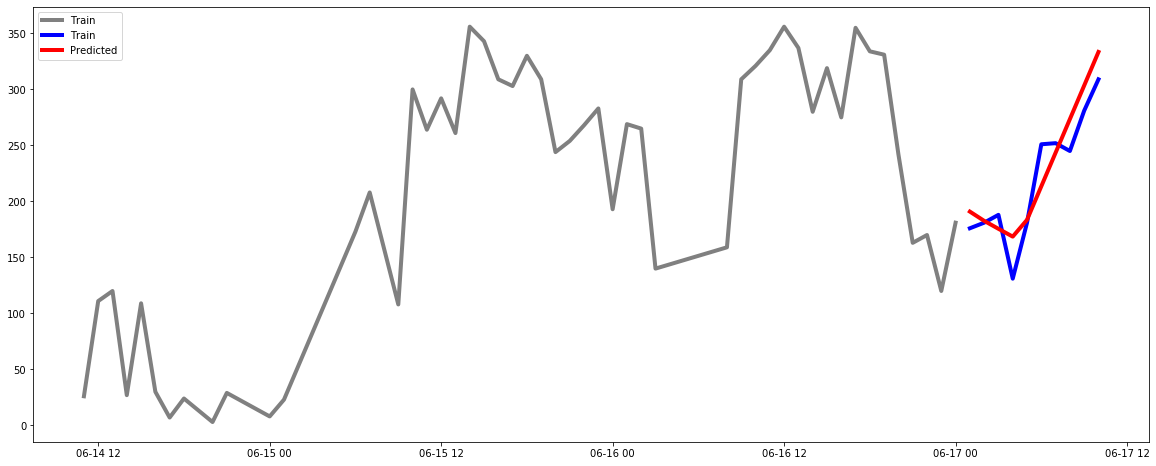

22.775505446803813
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=7206.539, BIC=7229.061, Fit time=50.664 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=7576.625, BIC=7585.634, Fit time=0.822 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=7380.290, BIC=7398.308, Fit time=10.671 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=7238.809, BIC=7256.827, Fit time=26.611 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 52); AIC=7207.467, BIC=7234.493, Fit time=51.171 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 52); AIC=7537.148, BIC=7555.165, Fit time=5.318 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 52); AIC=7207.540, BIC=7234.566, Fit time=193.672 seconds


In [ ]:
RMSE = []
m = 0
for i in range(72,len(EM4),72):
    EM4_new = EM4.iloc[m:i]
    m=i
    n = 72
#     model = EM4_new[-(n):]
    train = EM4_new[0 : (n-10)]
    test = EM4_new[-10:]
    yhat = test.copy()
    import warnings
    warnings.filterwarnings('ignore')
#     x = 12
#     y = auto_arima(train, trace = True, seasonal = True, m = x)
    y = auto_arima(EM4, start_p=1, start_q=1, max_p=3, max_q=3, m=52, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
    print(y.aic())
    order = list(y.order)
    seasonal_order = list(y.seasonal_order)
    a = len(test)
    model = SARIMAX(train, order = order, seasonal_order = seasonal_order, typ = 'levels').fit(disp = False, transparams = False, trend = 'c', solver = 'nm')
    yhat['predictions'] = model.forecast(a)
    yhat['rms'] = sqrt(mean_squared_error(test.EM4, yhat['predictions']))
    plt.figure(figsize=(20,8))
#     plt.plot(EM4['EM4'])
    plt.plot(train['EM4'], label='Train', lw = 4, color = 'grey')
    plt.plot(test['EM4'], label='Train', lw = 4, color = 'blue')
    plt.plot(yhat['predictions'], label='Predicted', lw = 4, color = 'red')
    plt.legend(loc='best')
    plt.show()
    r = yhat['rms'].mean()
    RMSE.append(r)
    print(yhat['rms'].mean())
    
# print(RMSE)
#     print(yhat['predictions'])

In [ ]:
statistics.mean(RMSE)